# Notebook 2/3 - Data exploration

### General objective of the project
- Predict daily solar energy on next day for the city of Kraainem, in Belgium

### Notebook objective
- Improve understanding of the cleaned and formated data via exploration and visualization
- Observe level, trend, seasonality and noise in the target feature
- Assess relations between the target feature and its drivers
- Perform additional feature engineering and or feature selection depending on findings

### Import modules

In [1]:
# import modules
import pandas as pd
from pandas.plotting import autocorrelation_plot as aurocorr
import numpy as np

from statsmodels.tsa.seasonal import seasonal_decompose as sdecomp
from statsmodels.tsa.stattools import adfuller

from sklearn.ensemble import RandomForestRegressor as rfr

from matplotlib import pyplot as plt
import seaborn as sns

### Set graphic style

In [2]:
# set visualization style
palette_1 = sns.color_palette('Set1')
palette_2 = sns.light_palette(color='red', n_colors=12)
palette_3 = sns.diverging_palette(h_neg=9, h_pos=250, as_cmap=True)
sns.set_theme(
    style='whitegrid',
    palette=palette_1,
    font_scale=1.2
)

### Load data

In [3]:
# import cleaned and formated dataset
load_path = '../data/formated/'
load_name = 'sol_temp.csv'

sol_temp = pd.read_csv(
    load_path + load_name,
    index_col=0,
    parse_dates=True,
    infer_datetime_format=True
)

In [4]:
# check dataframe size and content
sol_temp.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1075 entries, 2019-01-07 to 2021-12-16
Data columns (total 64 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Year_t                      1075 non-null   int64  
 1   Month_t                     1075 non-null   int64  
 2   Year_month_t                1075 non-null   object 
 3   Temp_t                      1075 non-null   float64
 4   Temp_t_min_wk               1075 non-null   float64
 5   Temp_t_max_wk               1075 non-null   float64
 6   Temp_t_mean_wk              1075 non-null   float64
 7   Temp_t_std_wk               1075 non-null   float64
 8   Temp_t_mean_wk_velocity     1075 non-null   float64
 9   CloudOp_t                   1075 non-null   float64
 10  CloudOp_t_min_wk            1075 non-null   float64
 11  CloudOp_t_max_wk            1075 non-null   float64
 12  CloudOp_t_mean_wk           1075 non-null   float64
 13  CloudOp_t_std_w

In [5]:
# update format of the feature Year_month_t to period
sol_temp.Year_month_t = pd.to_datetime(sol_temp.Year_month_t).dt.to_period('M')

In [6]:
# check random entries
sol_temp.sample(3)

,Year_t,Month_t,Year_month_t,Temp_t,Temp_t_min_wk,Temp_t_max_wk,Temp_t_mean_wk,Temp_t_std_wk,Temp_t_mean_wk_velocity,CloudOp_t,...,DHI_t_mean_wk,DHI_t_std_wk,DHI_t_mean_wk_velocity,GHI_t,GHI_t_min_wk,GHI_t_max_wk,GHI_t_mean_wk,GHI_t_std_wk,GHI_t_mean_wk_velocity,GHI_t+1
Date,,,,,,,,,,,,,,,,,,,,,
2020-04-09,2020,4,2020-04,17.642857,8.214286,19.085714,14.664286,3.774133,1.478571,0.828571,...,123.765306,44.362543,-3.979592,401.500000,255.928571,414.071429,360.642857,58.346009,28.357143,421.857143
2021-04-11,2021,4,2021-04,5.278571,2.614286,9.657143,5.478571,2.272506,-0.473469,52.928571,...,149.418367,32.924347,-3.306122,167.214286,99.428571,310.571429,197.081633,74.693824,-8.795918,239.500000
2020-06-14,2020,6,2020-06,18.982353,13.852941,20.811765,16.996639,2.563565,0.622689,41.470588,...,172.546218,34.524229,-3.731092,318.941176,166.705882,456.705882,258.512605,103.343771,1.621849,426.117647


### Data dictionary
- `Temp_`: Daily average temperature in °C. Format: **float**
- `CloudOp_`: Daily average opacity of the clouds in %. Format: **float**
- `PrecipW_`: Daily average of [precipitable water](https://en.wikipedia.org/wiki/Precipitable_water), the depth of water in a column in kg/m² of the atmosphere if it all rained. Format: **float**
- `Humid_`: Daily average [relative humidity](https://en.wikipedia.org/wiki/Humidity), a state of absolute humidity relative to a maximum humidity, in %. Format: **float**
- `Press_`:Daily average [surface pressure](https://en.wikipedia.org/wiki/Atmospheric_pressure#Surface_pressure), the atmospheric pressure at a location on Earth's surface, in hPA. Format: **float** 
- `WindDir_`: Daily average wind direction, in °. Format: **float**
- `WindSpd_`: Daily average wind speed, in m/s. Format: **float**
- `DNI_`: Daily average [Diffused Normal Irradiance](https://www.yellowhaze.in/solar-irradiance/), the amount of light that is coming perpendicular to surface. Format: **float**
- `GHI_`: Daily average [Global Horizontal Irradiance](https://www.yellowhaze.in/solar-irradiance/), the total amount of shortwave radiation received from above by a surface which is horizontal. Format: **float**
- `DHI_`: Daily average [Diffused Horizontal Irradiance](https://www.yellowhaze.in/solar-irradiance/), the solar radiations that do not arrive on a direct path from the sun, but has been scattered by clouds and particles in the atmosphere and comes equally from all directions. Format: **float**

### Important notes
- Features ending with _t are daily averages of hourly measures. 
- Features ending with _wk are weekly averages (average of the 7 records before the record at t-time)
- Features ending with _velocity are rate of change between t+1 and t
- '_t' stands for t-time, to be used as X for ML models  
- '_t+1' stands for t-time+1, to be used as y for ML models

### Explore and visualize data

In [7]:
# create lists of features per topic: weather, irradiation. Features Years and Month are not considerer
wx_complete_feat = list(sol_temp.columns)[3:45]
wx_record_t_feat = [
    'Temp_t',
    'CloudOp_t',
    'PrecipW_t',
    'Humid_t',
    'Press_t',
    'WindDir_t',
    'WindSpd_t'
]

irr_complete_feat = list(sol_temp.columns)[45:64]
irr_record_t_feat = [
    'DNI_t',
    'DHI_t',
    'GHI_t',
    'GHI_t+1'
]

wx_irr_complete_feat = wx_complete_feat + irr_complete_feat
wx_irr_record_t_feat = wx_record_t_feat + irr_record_t_feat

# create lists of complete names for features
wx_record_t_feat_names = [
    'Temperature',
    'Cloud Opacity',
    'Precipitable Water',
    'Humidity (rel.)',
    'Pressure',
    'Wind Direction',
    'Wind Speed'
]

irr_record_t_feat_names = [
    'Diffused Normal Irradiance',
    'Diffused Horizontal Irradiance',
    'Global Horizontal Irradiance',
    'Global Horizontal Irradiance (t+1)',

]

# create lists of measure units
wx_feat_units = [
    '°C',
    '%',
    'kg/m²',
    '%',
    'hPA',
    '°',
    'm/s'
]

In [8]:
# check irradiation feature distributions
sol_temp[irr_complete_feat].describe().T

,count,mean,std,min,25%,50%,75%,max
DNI_t,1075.0,206.667260,210.060770,0.000000,20.516667,130.538462,352.166667,738.923077
DNI_t_min_wk,1075.0,28.989328,65.777955,0.000000,0.000000,0.687500,19.444444,448.000000
DNI_t_max_wk,1075.0,450.738557,174.222590,7.764706,295.716667,498.400000,612.615385,738.923077
DNI_t_mean_wk,1075.0,206.534185,130.051826,2.504727,103.681662,173.882353,296.278442,620.098901
DNI_t_std_wk,1075.0,164.273190,69.041478,3.441290,105.316482,169.049200,219.489339,343.395143
DNI_t_mean_wk_velocity,1075.0,0.063571,41.043976,-97.955357,-23.519264,0.000000,23.722222,100.904762
DHI_t,1075.0,122.334119,57.959268,27.900000,73.303846,114.833333,168.313725,261.875000
DHI_t_min_wk,1075.0,79.977567,38.762164,27.900000,45.000000,75.200000,99.805195,207.625000
DHI_t_max_wk,1075.0,163.790404,60.926810,52.500000,105.300000,164.769231,220.705882,261.875000
DHI_t_mean_wk,1075.0,122.326225,48.295892,42.507937,77.542208,123.361905,162.257666,232.383403


In [9]:
# check weather feature distributions
sol_temp[wx_complete_feat].describe().T

,count,mean,std,min,25%,50%,75%,max
Temp_t,1075.0,12.547345,6.244631,-5.360000,7.845299,12.193333,17.639076,32.493750
Temp_t_min_wk,1075.0,9.838417,5.795327,-5.360000,5.292308,9.643750,14.953846,26.713333
Temp_t_max_wk,1075.0,15.647880,6.127370,-2.090000,10.815385,15.181818,20.123077,32.493750
Temp_t_mean_wk,1075.0,12.535342,5.862516,-3.992857,7.831175,12.351299,17.542332,28.790298
Temp_t_std_wk,1075.0,2.136530,0.999750,0.229860,1.400863,2.008404,2.641980,6.698795
Temp_t_mean_wk_velocity,1075.0,0.001944,0.621422,-2.187206,-0.377124,-0.024675,0.375794,2.187792
CloudOp_t,1075.0,34.359094,22.046529,0.000000,15.272778,35.654545,51.566667,83.608333
CloudOp_t_min_wk,1075.0,11.291952,12.231802,0.000000,0.635714,6.723529,20.613333,52.482353
CloudOp_t_max_wk,1075.0,59.411179,14.348665,0.515385,51.492857,62.428571,68.841667,83.608333
CloudOp_t_mean_wk,1075.0,34.399487,13.473893,0.113187,24.980570,34.571429,44.307468,63.814286


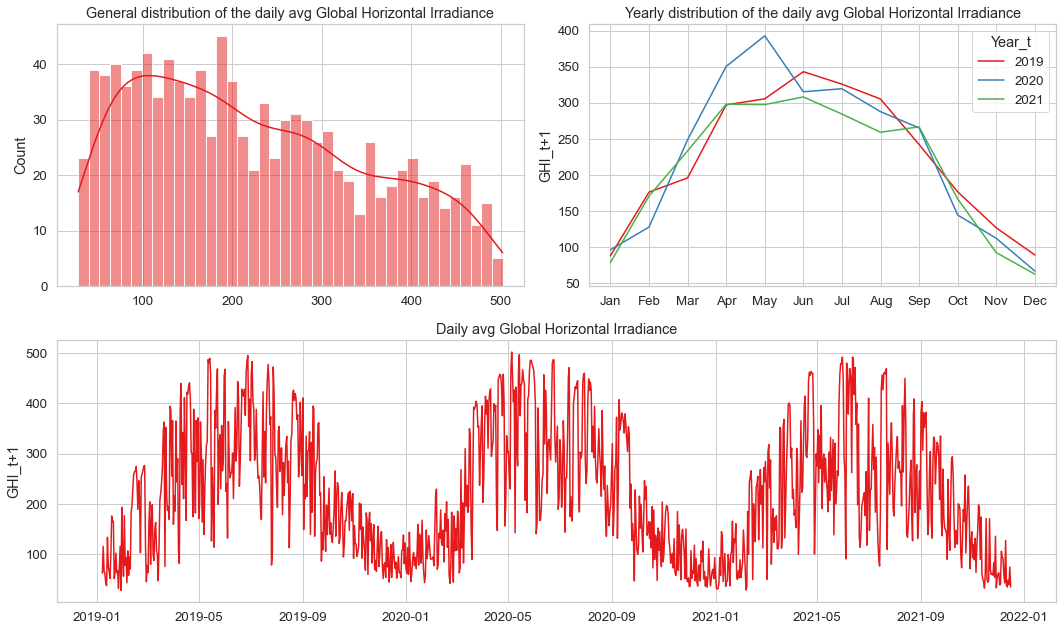

In [10]:
# visualize the distributions and trend of GHI_t+1 as it is the target feature
plt.figure(figsize=(15, 9))

# general distribution 
plt.subplot(2,2,1)
sns.histplot(
    sol_temp, 
    x='GHI_t+1', 
    kde=True,
    bins=40
)
plt.title('General distribution of the daily avg Global Horizontal Irradiance')
plt.xlabel(None)

# yearly distribution
plt.subplot(2,2,2)
sns.lineplot(
    data=sol_temp,
    x='Month_t',
    y='GHI_t+1', 
    hue='Year_t',
    palette=palette_1[:3],
    ci=None
)
plt.title('Yearly distribution of the daily avg Global Horizontal Irradiance')
plt.xticks(
    range(1, 13),
    ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
)
plt.xlabel(None)

# trend from 2019 to 2021, per day 
plt.subplot(2,2,(3,4))
sns.lineplot(
    data=sol_temp, 
    x=sol_temp.index,
    y='GHI_t+1'
)
plt.title('Daily avg Global Horizontal Irradiance')
plt.xlabel(None)

plt.tight_layout()
plt.show()

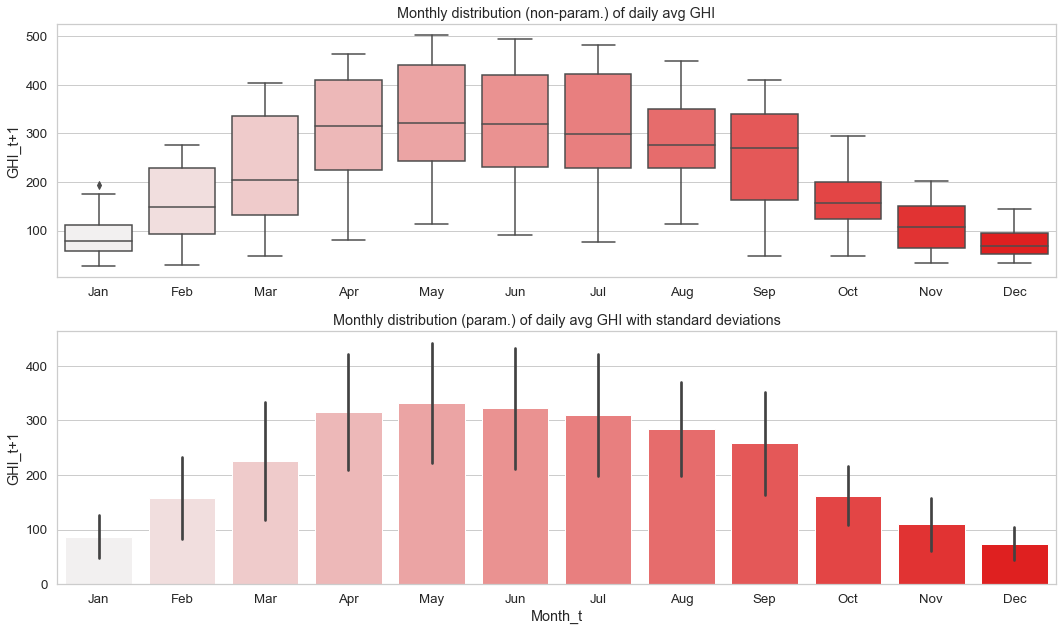

In [11]:
# there is a strong seasonality in daily GHI (peak in summer, low in winter); visualize monthly avg GHI
plt.figure(figsize=(15, 9))

plt.subplot(2, 1, 1)
sns.boxplot(
    data=sol_temp,
    x='Month_t',
    y='GHI_t+1',
    palette=palette_2
)
plt.title('Monthly distribution (non-param.) of daily avg GHI')
plt.xlabel(None)
plt.xticks(
    range(12),
    ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
)

plt.subplot(2, 1, 2)
sns.barplot(
    data=sol_temp,
    x='Month_t',
    y='GHI_t+1',
    palette=palette_2,
    ci='sd'
)
plt.title('Monthly distribution (param.) of daily avg GHI with standard deviations')
plt.xticks(
    range(12),
    ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
)

plt.tight_layout()
plt.show()

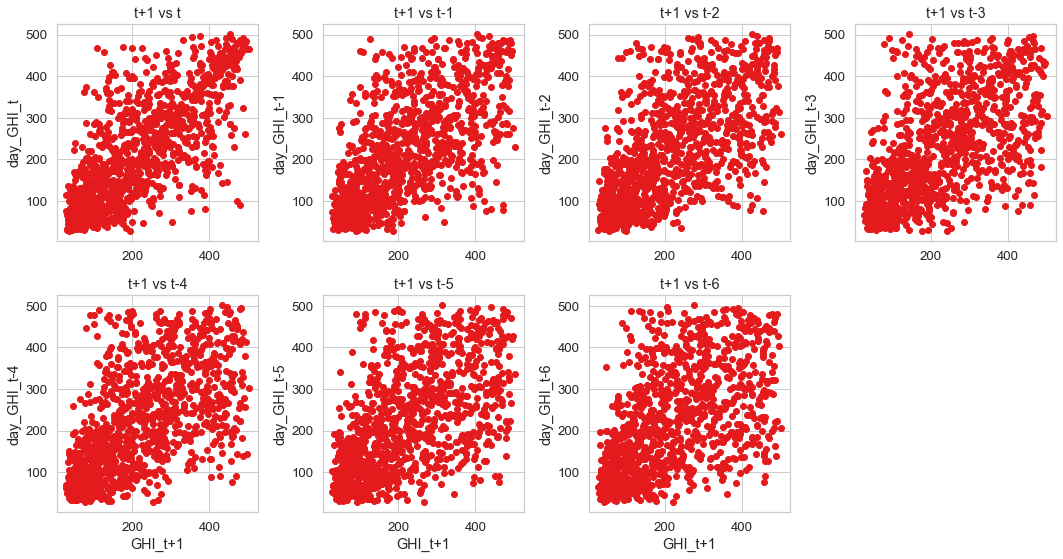

In [12]:
# visualize relations between GHI_t+1 and lagged values up to 7 periods
lag = 7
counter = 1
periods = ['t', 't-1', 't-2', 't-3', 't-4', 't-5', 't-6']

plt.figure(figsize=(15, 8))
for l in range(1, lag+1):
    plt.subplot(2, 4, counter)
    plt.scatter(
        x=sol_temp['GHI_t+1'],
        y=sol_temp['GHI_t+1'].shift(l)
    )
    plt.title('t+1 vs ' + periods[l-1])
    if counter in [5, 6, 7]:
        plt.xlabel('GHI_t+1')
    else:
        plt.xlabel(None)
    plt.ylabel('day_GHI_' + periods[l-1])
    counter += 1
    
plt.tight_layout()
plt.show()

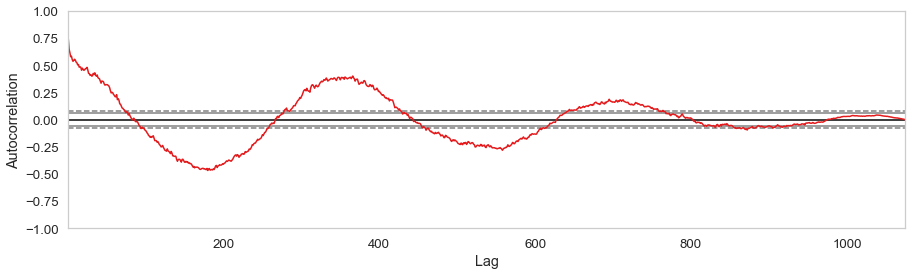

In [13]:
# visualize self-correlation of GHI_t+1 over multiple lag periods
plt.figure(figsize=(15, 4))
aurocorr(
    sol_temp['GHI_t+1']
)
plt.show()

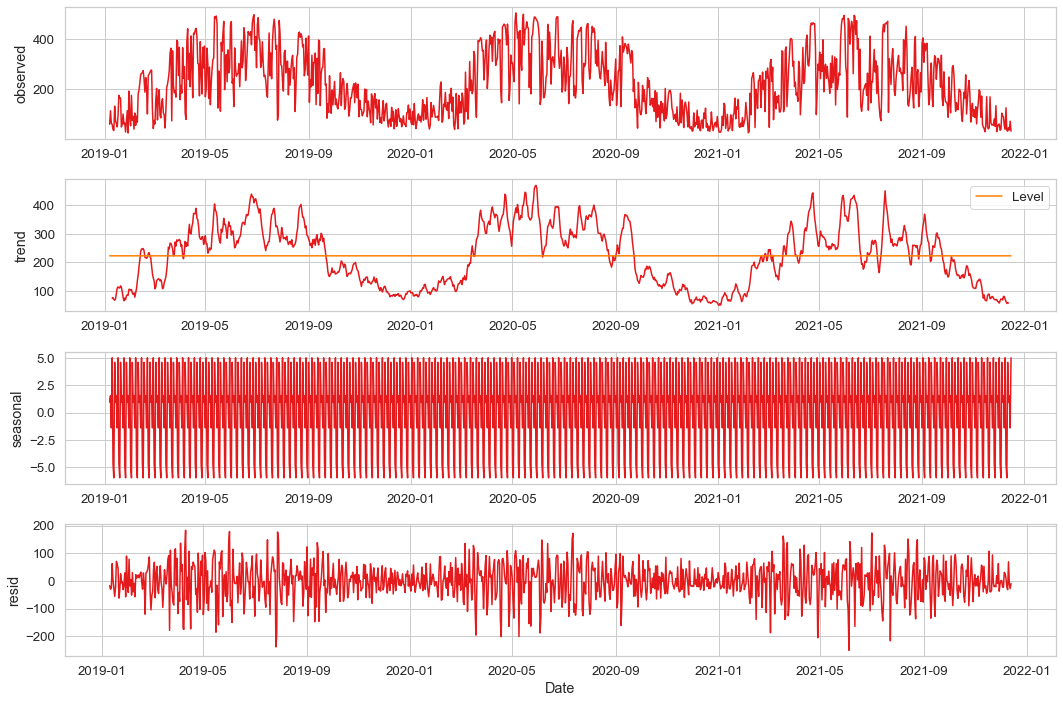

In [14]:
# separate the components of the GHI_t+11 time series (trend, seasonality, noise)
decomp = sdecomp(
    x=sol_temp['GHI_t+1'],
    model='additive'
)

# create a series with the mean day_DHI_t1 (i.e. level) and of same length as dataframe 
level_series = [sol_temp['GHI_t+1'].mean() for date in sol_temp.index]

# visualize the components of the day_DHI_t1 time series 
plt.figure(figsize=(15, 10))

# observed
plt.subplot(4, 1, 1)
sns.lineplot(
    data=decomp,
    x=decomp.observed.index,
    y=decomp.observed.values
)
plt.xlabel(None)
plt.ylabel('observed')

# trend & level
plt.subplot(4, 1, 2)
# trend
sns.lineplot(
    data=decomp,
    x=decomp.trend.index,
    y=decomp.trend.values
)
# level
plt.plot(
    sol_temp.index,
    level_series,
    color=palette_1[4],
    label='Level'
)
plt.legend()
plt.xlabel(None)
plt.ylabel(decomp.trend.name)

# seasonality
plt.subplot(4, 1, 3)
sns.lineplot(
    data=decomp,
    x=decomp.seasonal.index,
    y=decomp.seasonal.values
)
plt.xlabel(None)
plt.ylabel(decomp.seasonal.name)

# residuals
plt.subplot(4, 1, 4)
sns.lineplot(
    data=decomp,
    x=decomp.resid.index,
    y=decomp.resid.values
)
plt.ylabel(decomp.resid.name)

plt.tight_layout()
plt.show()

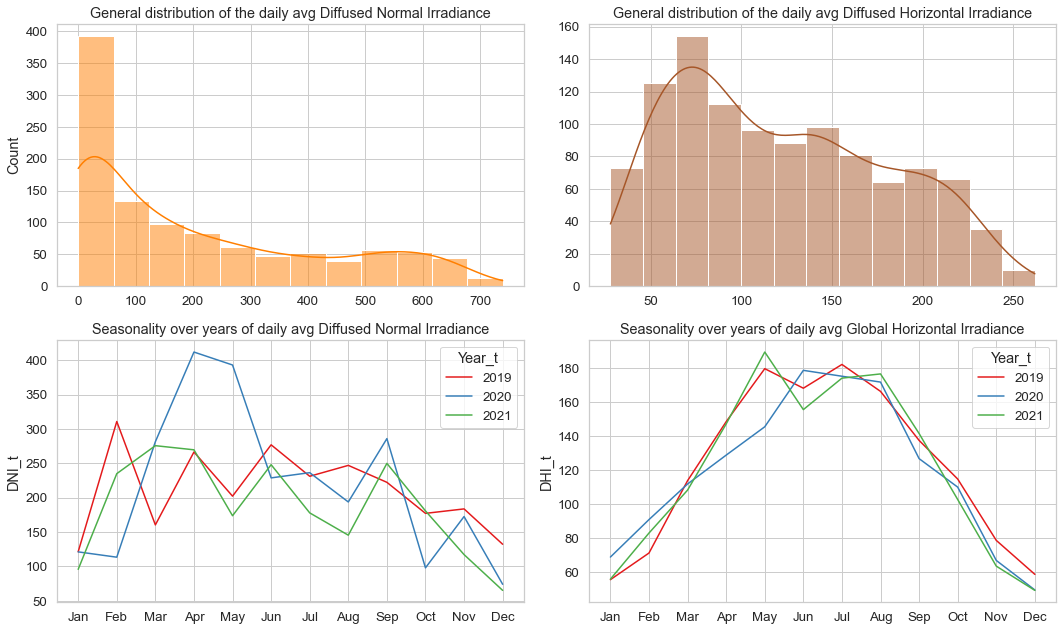

In [15]:
# visualize distributions and trend of the remaining irradiations features
plt.figure(figsize=(15, 9))

# DNI_t general distribution
plt.subplot(2, 2, 1)
sns.histplot(
    data=sol_temp,
    x='DNI_t',
    kde=True,
    color=palette_1[4]
)
plt.title('General distribution of the daily avg Diffused Normal Irradiance')
plt.xlabel(None)

# DHI_t general distribution
plt.subplot(2, 2, 2)
sns.histplot(
    data=sol_temp,
    x='DHI_t',
    kde=True,
    color=palette_1[6]
)
plt.title('General distribution of the daily avg Diffused Horizontal Irradiance')
plt.xlabel(None)
plt.ylabel(None)

# DNI_t trend per year from 2019 to 2021
plt.subplot(2, 2, 3)
sns.lineplot(
    data=sol_temp,
    x='Month_t',
    y='DNI_t',
    hue='Year_t',
    palette=palette_1[:3],
    ci=None
)
plt.title('Seasonality over years of daily avg Diffused Normal Irradiance')
plt.xticks(
    range(1, 13),
    ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
)
plt.xlabel(None)

# DHI_t trend per year from 2019 to 2021
plt.subplot(2, 2, 4)
sns.lineplot(
    data=sol_temp,
    x='Month_t',
    y='DHI_t',
    hue='Year_t',
    palette=palette_1[:3],
    ci=None
)
plt.title('Seasonality over years of daily avg Global Horizontal Irradiance')
plt.xticks(
    range(1, 13),
    ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
)
plt.xlabel(None)

plt.tight_layout()
plt.show()

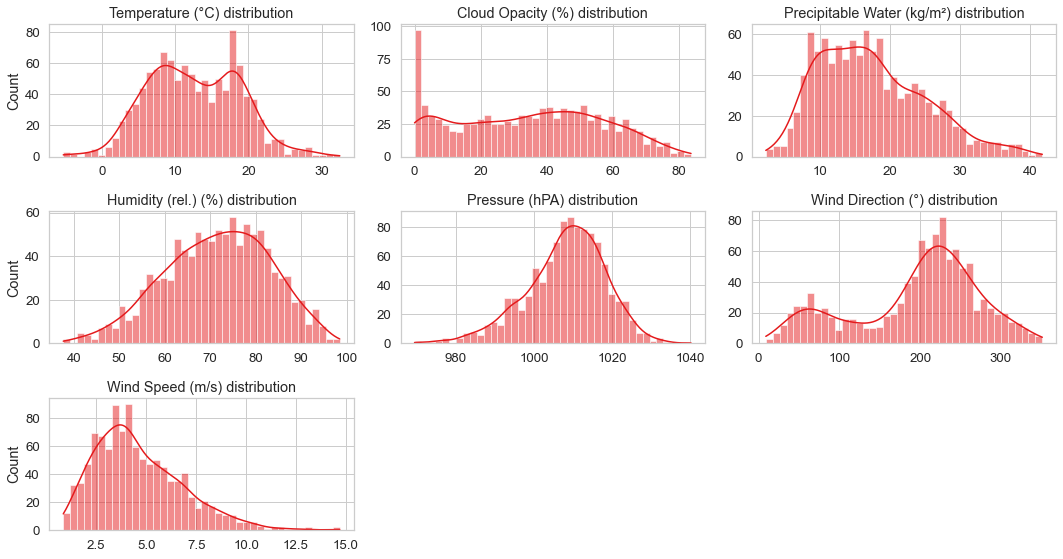

In [16]:
# visualize distributions of the weather features
plt.figure(figsize=(15, 8))

counter=1

for feat in wx_record_t_feat:
    plt.subplot(3, 3, counter)
    sns.histplot(
        data=sol_temp,
        x=feat,
        kde=True,
        bins=40
    )
    plt.title(wx_record_t_feat_names[counter-1] + ' (' + wx_feat_units[counter-1] + ') distribution')
    plt.xlabel(None)
    if counter in [2, 3, 5, 6]:
        plt.ylabel(None)
    counter += 1

plt.tight_layout()
plt.show()

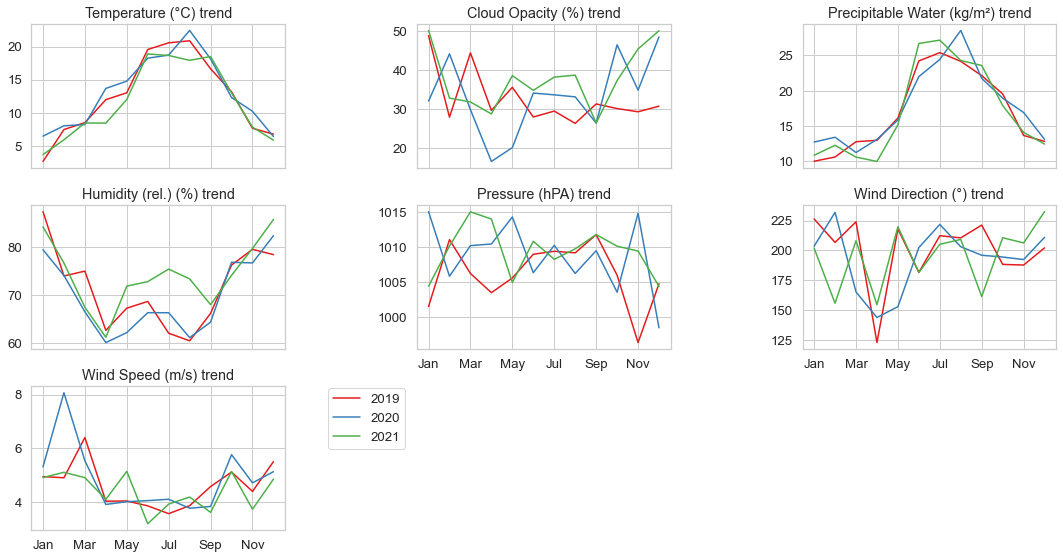

In [17]:
# visualize seasonality over years of the weather features
plt.figure(figsize=(15, 8))

counter=1

for feat in wx_record_t_feat:
    plt.subplot(3, 3, counter)
    sns.lineplot(
        data=sol_temp,
        x='Month_t',
        y=feat,
        hue='Year_t',
        palette=palette_1[:3],
        ci=None,
        legend=False
    )
    plt.title(wx_record_t_feat_names[counter-1] + ' (' + wx_feat_units[counter-1] + ') trend')
    plt.xlabel(None)
    plt.ylabel(None)
    if counter in [5, 6, 7]:
        plt.xticks(
            range(1, 13, 2),
            ['Jan', 'Mar', 'May','Jul', 'Sep', 'Nov']
        )
    else:
        plt.xticks(
            range(1, 13, 2),
            []
        )
    if counter == 7:
        plt.legend([2019, 2020, 2021], bbox_to_anchor=(1.5, 1.03))
    counter += 1

plt.tight_layout()
plt.show()

### Evaluate relations within data

In [18]:
# create a list with only independant features
wx_irr_record_t_ind_feat = wx_irr_record_t_feat.copy()
wx_irr_record_t_ind_feat.remove('GHI_t')
wx_irr_record_t_ind_feat.remove('GHI_t+1')

# create a list with clean names of only independant features
wx_irr_ind_feat_names = wx_record_t_feat_names + irr_record_t_feat_names
wx_irr_ind_feat_names.remove('Global Horizontal Irradiance')

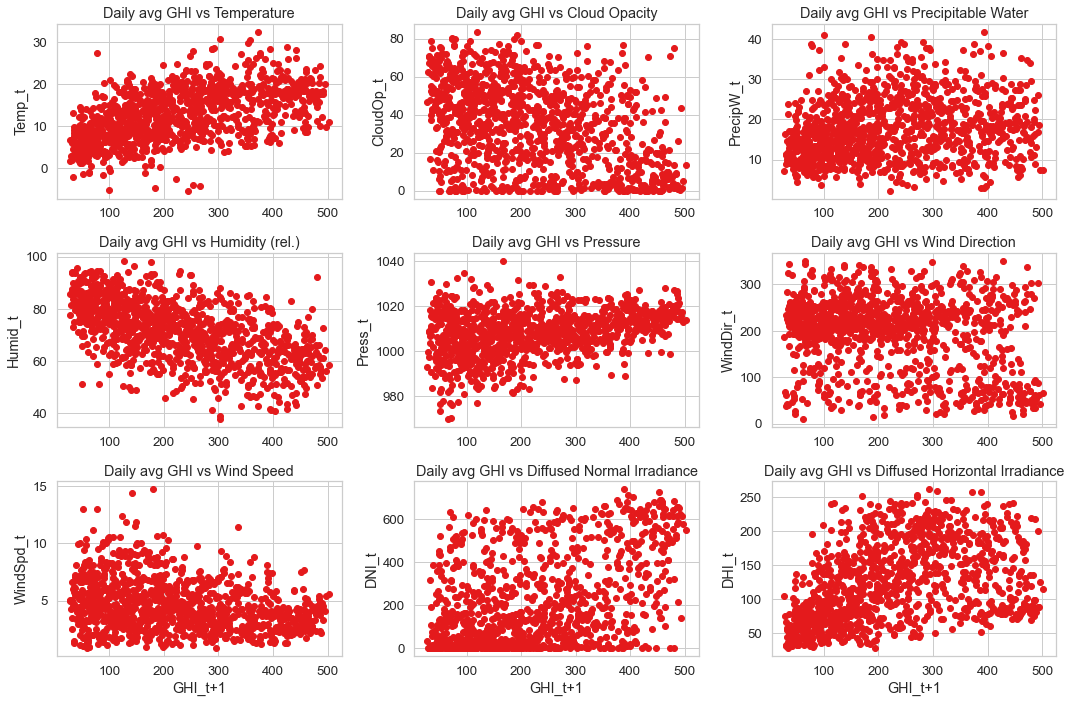

In [19]:
# plot target feature vs weather features
plt.figure(figsize=(15, 10))

counter=1

for feat in wx_irr_record_t_ind_feat:
    plt.subplot(3, 3, counter)
    plt.scatter(
        sol_temp['GHI_t+1'],
        sol_temp[feat],
    )
    plt.title('Daily avg GHI vs ' + wx_irr_ind_feat_names[counter-1])
    plt.ylabel(feat)
    if counter in [7, 8, 9]:
        plt.xlabel('GHI_t+1')
    else:
        plt.xlabel(None)
    counter += 1

plt.tight_layout()
plt.show()

In [20]:
# statistically check if day_DHI_t1 follows a stationary or non-stationary trend with an augmented Dickey-Fuller (ADF) test
# Test conditions:
# H0 = trend is non-stationary & H1 = trend is stationary
# significance level of 5%

alpha = .05

# perform the ADF test
adf = adfuller(sol_temp['GHI_t+1'])

# return result of the test
print('adf test stat. = ', round(adf[0], 4))
print('adf critical val. = ', round(adf[4]['5%'], 4))
print('p-val. = ', round(adf[1], 4))

if (adf[1] < alpha) & (adf[0] < adf[4]['5%']):
    print('H0 is rejected, the trend in GHI_t+1 is stationary.')
else:
    print('We cannot reject H0, the trend in GHI_t+1 is non-stationary.')

adf test stat. =  -3.5719
adf critical val. =  -2.8643
p-val. =  0.0063
H0 is rejected, the trend in GHI_t+1 is stationary.


In [21]:
# add GHI_t+1 to the complete list of wx features 
wx_complete_feat.insert(0, 'GHI_t+1')

# add Year_t and Month_t to the complete list of wx features
wx_complete_feat.append('Year_t')
wx_complete_feat.append('Month_t')

# calculate correlation between wx features and GHI_t+1
corr_map_wx = sol_temp[wx_complete_feat].corr()

# limit dataframe of correlations to relations where correlation is stronger than abs(0.1)
trim_corr_map_wx = corr_map_wx[abs(corr_map_wx['GHI_t+1']) > .1]

# drop the column which where remove at the previous step to keep a square dataframe
col_to_drop = []
for col in list(trim_corr_map_wx.columns):
    if col not in list(trim_corr_map_wx.index):
        col_to_drop.append(col)

trim_corr_map_wx = trim_corr_map_wx.drop(
    labels=col_to_drop, 
    axis=1
)

In [22]:
# inspect correlation table between wx features and GHI_t+1, where correlation is > 0.1 in absolute term
trim_corr_map_wx.sort_values(
    'GHI_t+1',
    ascending=False
)

,GHI_t+1,Temp_t,Temp_t_min_wk,Temp_t_max_wk,Temp_t_mean_wk,Temp_t_mean_wk_velocity,CloudOp_t,CloudOp_t_min_wk,CloudOp_t_max_wk,CloudOp_t_mean_wk,...,WindDir_t_min_wk,WindDir_t_mean_wk,WindDir_t_mean_wk_velocity,WindDir_t_std_wk,WindSpd_t,WindSpd_t_min_wk,WindSpd_t_max_wk,WindSpd_t_mean_wk,WindSpd_t_std_wk,Month_t
GHI_t+1,1.000000,0.541700,0.522201,0.523252,0.535073,0.143481,-0.396079,-0.212514,-0.270209,-0.383982,...,-0.239442,-0.207971,-0.127267,0.240695,-0.270702,-0.174407,-0.346639,-0.321634,-0.278910,-0.130169
Temp_t,0.541700,1.000000,0.902228,0.886845,0.911579,0.345436,-0.232402,-0.131554,-0.380863,-0.370464,...,-0.049480,-0.049267,0.018150,0.024428,-0.199784,-0.147518,-0.441174,-0.369103,-0.417014,0.247622
Temp_t_mean_wk,0.535073,0.911579,0.973199,0.967789,1.000000,0.049534,-0.182987,-0.131863,-0.379330,-0.366051,...,-0.045279,-0.043262,0.020185,0.028423,-0.224285,-0.161087,-0.441374,-0.368172,-0.402660,0.301008
Temp_t_max_wk,0.523252,0.886845,0.906784,1.000000,0.967789,0.055134,-0.190395,-0.168885,-0.386896,-0.389984,...,-0.064939,-0.074772,0.024182,0.037595,-0.200532,-0.157208,-0.415491,-0.347538,-0.379880,0.263060
Temp_t_min_wk,0.522201,0.902228,1.000000,0.906784,0.973199,0.040942,-0.174348,-0.090989,-0.356841,-0.325463,...,-0.016649,-0.002936,0.020263,0.011973,-0.224683,-0.168550,-0.425310,-0.363497,-0.379730,0.330963
Press_t_min_wk,0.399660,0.395486,0.392209,0.385916,0.394882,0.084829,-0.286375,-0.341629,-0.398621,-0.490314,...,-0.295174,-0.208484,-0.111929,0.287714,-0.275189,-0.269528,-0.486297,-0.461102,-0.395897,-0.111366
PrecipW_t_mean_wk,0.324854,0.793037,0.870446,0.839620,0.880736,-0.003386,0.003455,0.087699,-0.096352,-0.022812,...,0.090183,0.133210,0.054706,-0.084208,-0.132383,-0.065405,-0.345706,-0.247308,-0.357113,0.385105
PrecipW_t_min_wk,0.315392,0.758937,0.843205,0.766134,0.829099,-0.017343,0.031522,0.181424,-0.094810,0.033585,...,0.101060,0.149735,0.050024,-0.079794,-0.175681,-0.089867,-0.351083,-0.267226,-0.346629,0.355252
Press_t,0.307172,0.078335,0.110663,0.089724,0.100814,-0.043221,-0.438554,-0.257222,-0.225407,-0.298575,...,-0.164620,-0.062965,-0.193250,0.193203,-0.409948,-0.173888,-0.238942,-0.226432,-0.161636,-0.105036
PrecipW_t_max_wk,0.302902,0.741538,0.806148,0.814953,0.826410,-0.015232,-0.008788,0.019451,-0.051199,-0.067810,...,0.095975,0.120191,0.054965,-0.090151,-0.065951,-0.007774,-0.242442,-0.157133,-0.277759,0.360726


In [23]:
# create a mask for the visualization to have a "triangle" heatmap
corr_mask_wx = np.triu(
    np.ones_like(
        trim_corr_map_wx,
        dtype=bool
    )
)

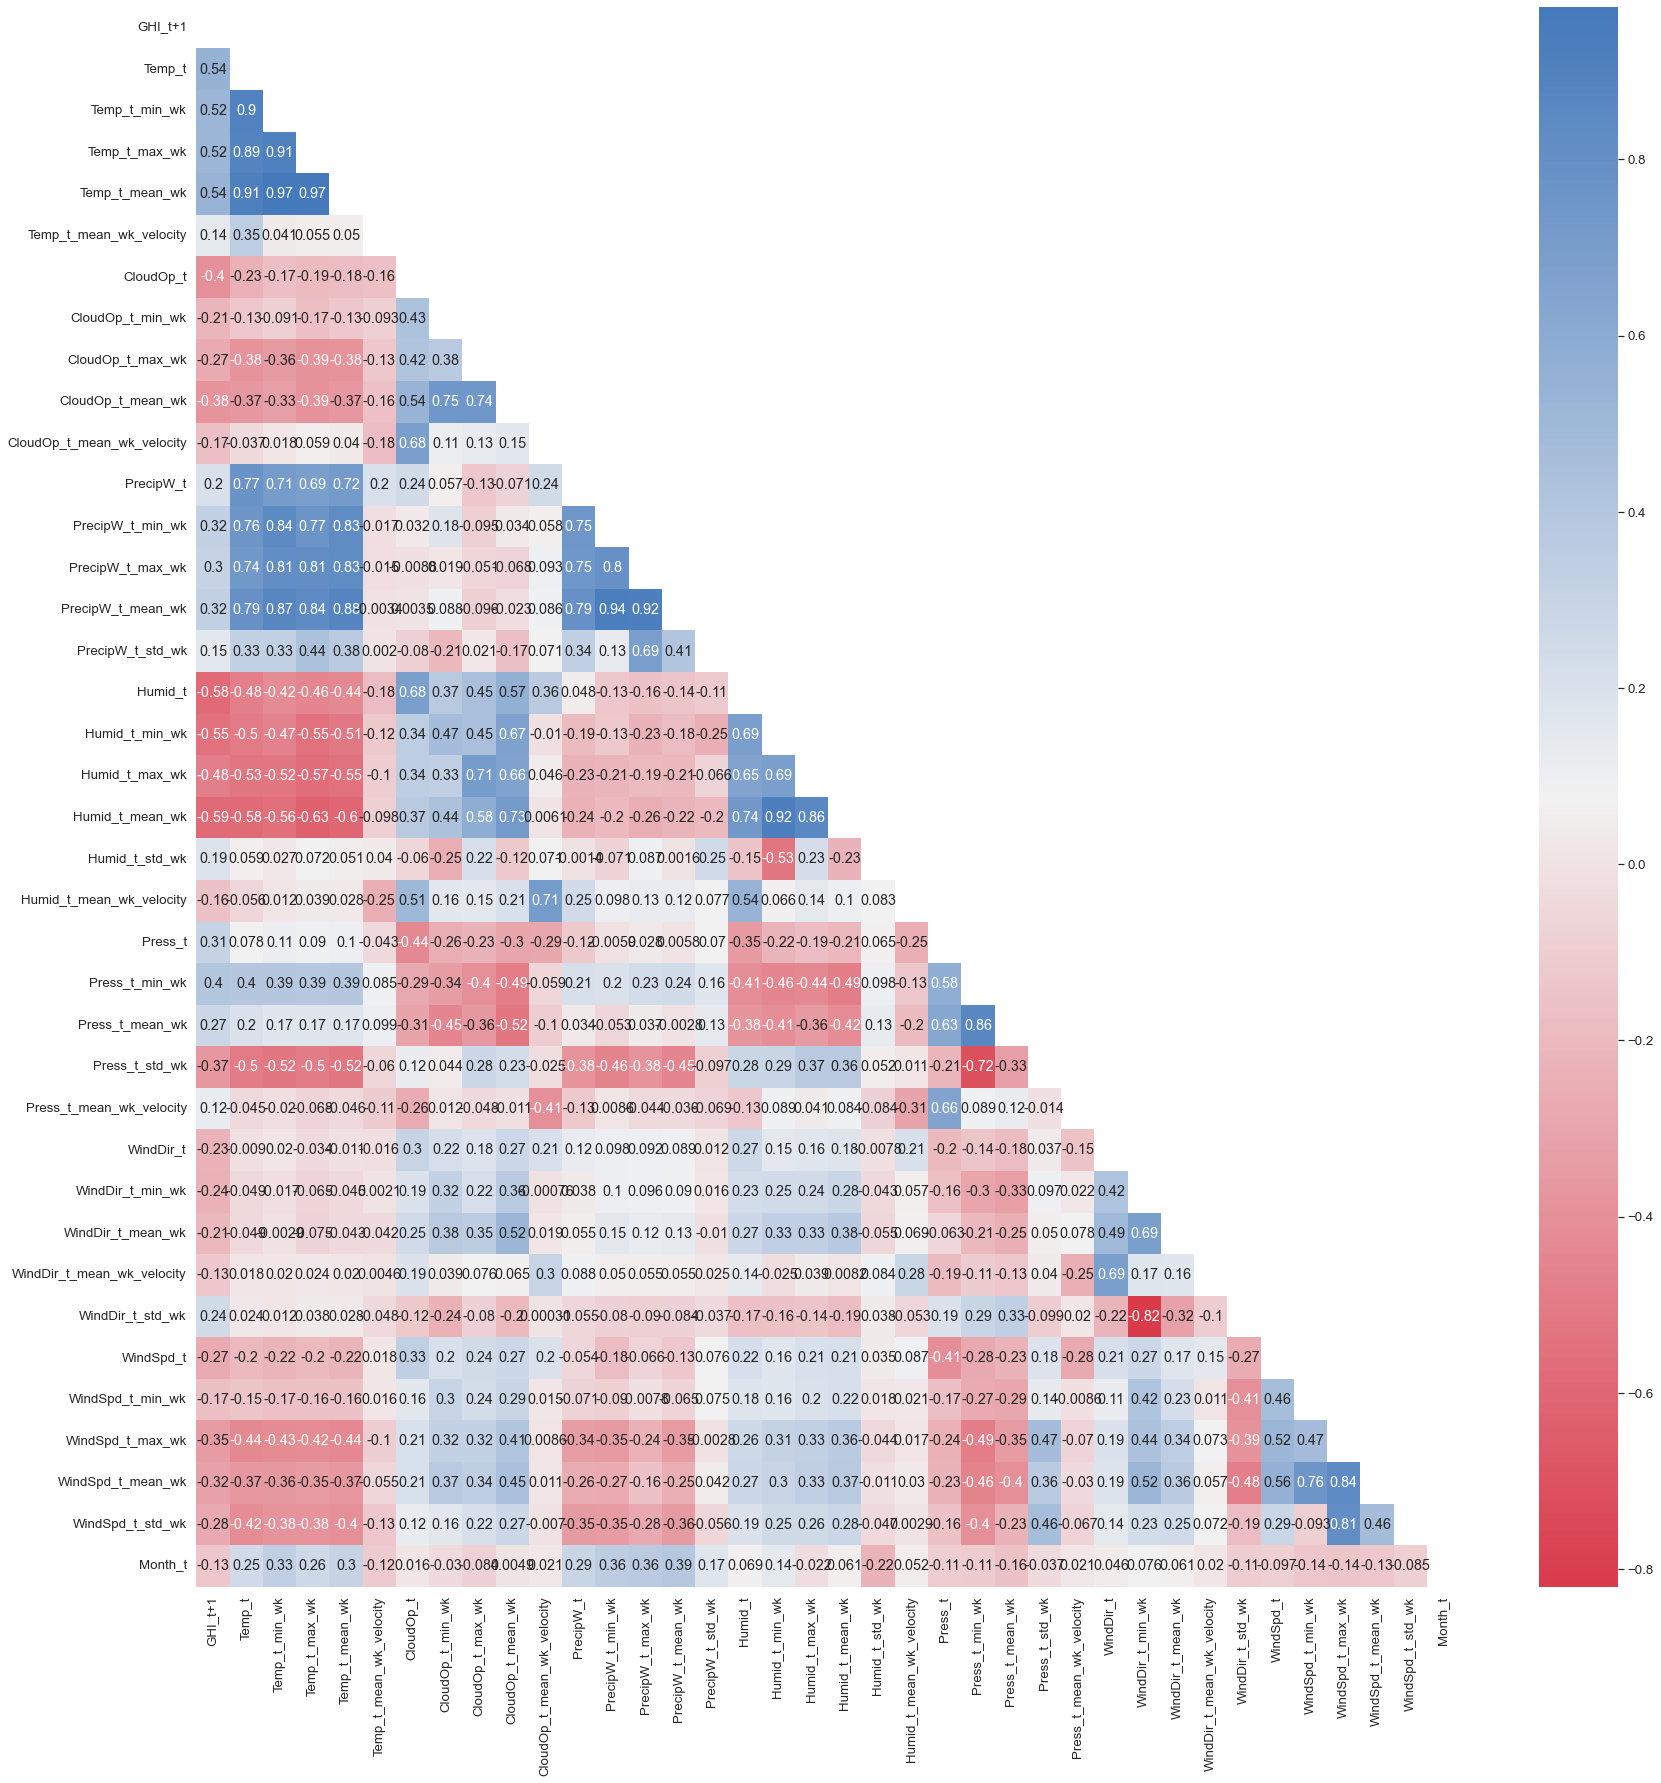

In [24]:
# visualize correlations, where relation is > 0.1 in absolute term
plt.figure(figsize=(25, 25))
sns.heatmap(
    trim_corr_map_wx,
    annot=True,
    mask=corr_mask_wx,
    cmap=palette_3
)

plt.tight_layout()
plt.show()

In [25]:
# move GHI_t+1 to the begining of the complete list of irr features 
irr_complete_feat.insert(0, 'GHI_t+1')
irr_complete_feat = irr_complete_feat[0:-1]

# calculate correlation between irr features and GHI_t+1
corr_map_irr = sol_temp[irr_complete_feat].corr()

In [26]:
# create a mask for the visualization to have a "triangle" heatmap
corr_mask_irr = np.triu(np.ones_like(corr_map_irr, dtype=bool))

In [27]:
# inspect correlation table between irr features and GHI_t+1
corr_map_irr.sort_values(
    'GHI_t+1',
    ascending=False
)

,GHI_t+1,DNI_t,DNI_t_min_wk,DNI_t_max_wk,DNI_t_mean_wk,DNI_t_std_wk,DNI_t_mean_wk_velocity,DHI_t,DHI_t_min_wk,DHI_t_max_wk,DHI_t_mean_wk,DHI_t_std_wk,DHI_t_mean_wk_velocity,GHI_t,GHI_t_min_wk,GHI_t_max_wk,GHI_t_mean_wk,GHI_t_std_wk,GHI_t_mean_wk_velocity
GHI_t+1,1.000000,0.451985,0.305239,0.345726,0.451168,0.225057,0.170493,0.446399,0.480673,0.682645,0.616948,0.610082,-0.079221,0.740504,0.592630,0.754214,0.732747,0.553126,0.191210
GHI_t_max_wk,0.754214,0.381776,0.372459,0.566077,0.632922,0.416839,0.041046,0.635689,0.549965,0.865348,0.753600,0.813185,-0.015157,0.797584,0.756545,1.000000,0.955103,0.761909,0.052050
GHI_t,0.740504,0.771106,0.436602,0.452465,0.583907,0.272810,0.418454,0.418261,0.445494,0.680482,0.597825,0.643294,-0.123390,1.000000,0.706356,0.797584,0.810252,0.508560,0.475639
GHI_t_mean_wk,0.732747,0.420442,0.530343,0.549015,0.749047,0.336105,0.061549,0.596183,0.530591,0.815670,0.695671,0.763857,-0.019927,0.810252,0.863887,0.955103,1.000000,0.597757,0.079882
DHI_t_max_wk,0.682645,0.174010,0.191301,0.168563,0.284068,0.074716,-0.040074,0.790378,0.788078,1.000000,0.945366,0.758554,0.059482,0.680482,0.679600,0.865348,0.815670,0.612965,-0.031841
DHI_t_mean_wk,0.616948,0.084088,0.110437,-0.015673,0.087941,-0.093066,-0.043586,0.812766,0.906379,0.945366,1.000000,0.554121,0.077197,0.597825,0.622210,0.753600,0.695671,0.486980,-0.033614
DHI_t_std_wk,0.610082,0.326553,0.246304,0.519385,0.533508,0.449854,0.021477,0.470836,0.222390,0.758554,0.554121,1.000000,-0.018492,0.643294,0.550461,0.813185,0.763857,0.691524,0.028215
GHI_t_min_wk,0.592630,0.359072,0.756658,0.364824,0.630500,0.053803,0.085852,0.525061,0.531064,0.679600,0.622210,0.550461,-0.038682,0.706356,1.000000,0.756545,0.863887,0.178563,0.114618
GHI_t_std_wk,0.553126,0.237491,-0.162706,0.531951,0.375667,0.641834,-0.016697,0.416482,0.275976,0.612965,0.486980,0.691524,0.004366,0.508560,0.178563,0.761909,0.597757,1.000000,-0.032192
DHI_t_min_wk,0.480673,-0.020270,0.072874,-0.226284,-0.047417,-0.290103,-0.065800,0.748232,1.000000,0.788078,0.906379,0.222390,0.098488,0.445494,0.531064,0.549965,0.530591,0.275976,-0.058155


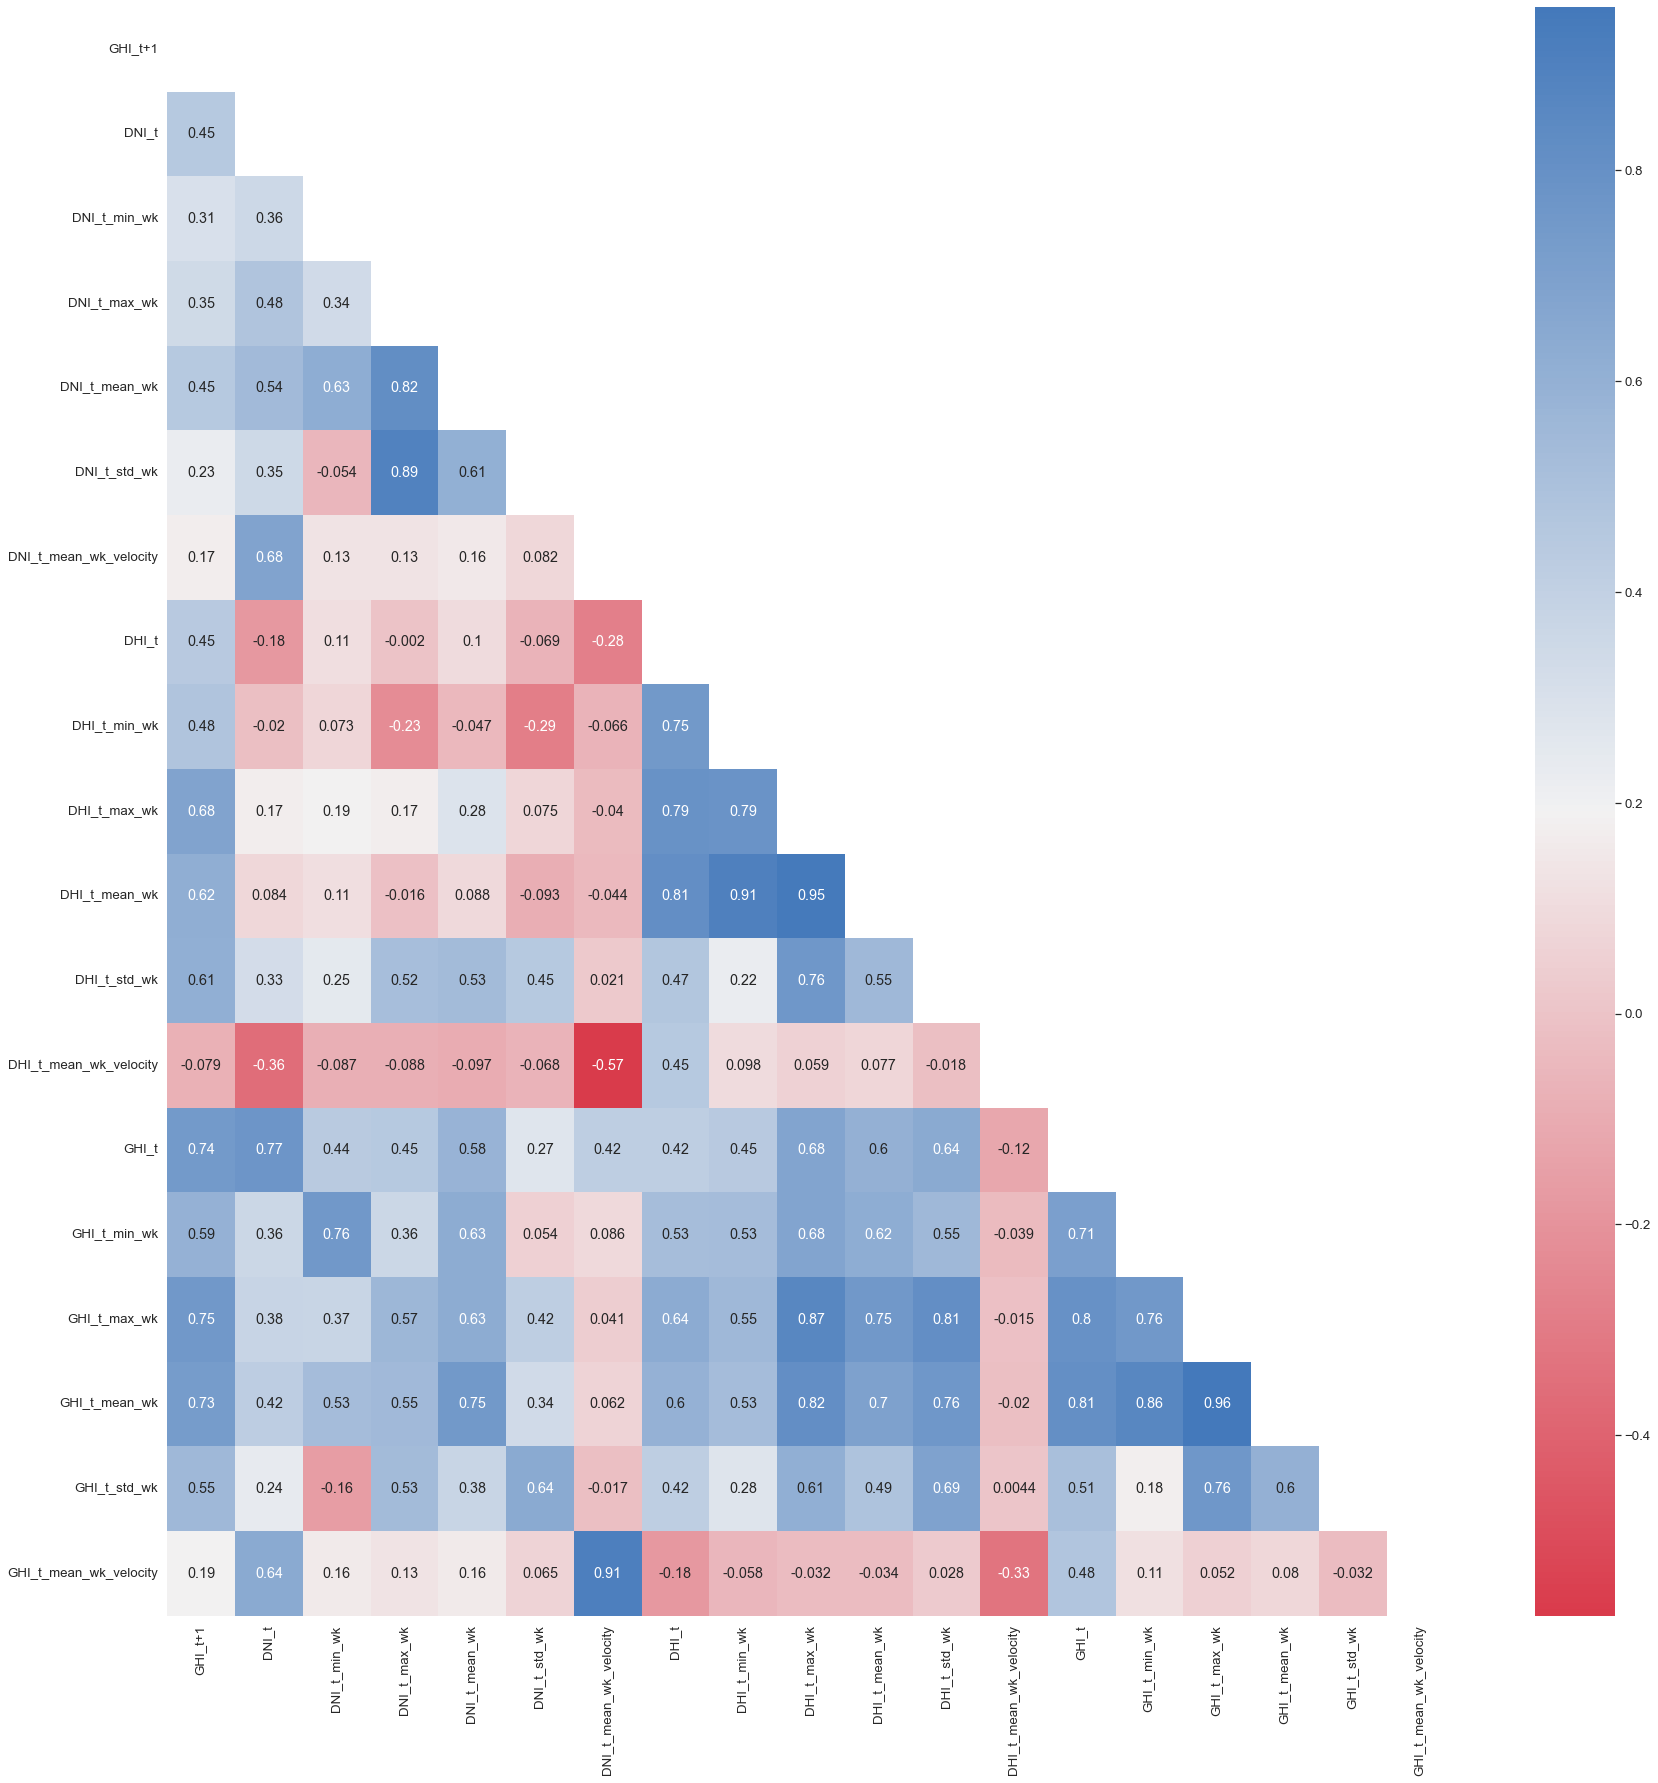

In [28]:
# visualize correlations
plt.figure(figsize=(25, 25))
sns.heatmap(
    corr_map_irr,
    annot=True,
    mask=corr_mask_irr,
    cmap=palette_3
)

plt.tight_layout()
plt.show()

In [29]:
# create list of wx features and their pearson correlation with GHI_t+1
wx_feat_pears_corr_series = corr_map_wx['GHI_t+1'].drop('GHI_t+1', axis=0)
wx_feat_pears_corr_lst = list(wx_feat_pears_corr_series.values)
wx_feat_pears_name_lst = list(wx_feat_pears_corr_series.index)

# create list of irr features and their pearson correlation with GHI_t+1
irr_feat_pears_corr_series = corr_map_irr['GHI_t+1'].drop('GHI_t+1', axis=0)
irr_feat_pears_corr_lst = list(irr_feat_pears_corr_series.values)
irr_feat_pears_name_lst = list(irr_feat_pears_corr_series.index)

# concatenate lists of wx and irr features and their pearson correlation with GHI_t+1
feat_corr_scores = wx_feat_pears_corr_lst + irr_feat_pears_corr_lst
feat_corr_names = wx_feat_pears_name_lst + irr_feat_pears_name_lst

In [30]:
# create a dictionary of features and their correlation with GHI_t+1 according to Pearson correlation
feat_corr_dict = {
    'feature': feat_corr_names,
    'pearson_corr': feat_corr_scores
}

# create a dataframe out of the previous dictionary
feat_corr_df = pd.DataFrame(feat_corr_dict)

In [31]:
# split into X and y to fit Random Forest Regressor (rfr)
X = sol_temp.drop(
    labels=
    [
        'GHI_t+1',
        'Year_month_t'
    ],
    axis=1
)
y = sol_temp['GHI_t+1']

# fit rfr on data
feat_imp = rfr(n_estimators=300)
feat_imp.fit(X, y)

RandomForestRegressor(n_estimators=300)

In [32]:
# create lists of features and importance scores
feat_imp_scores = []
feat_imp_names = []

for i in range(len(X.columns)):
    feat_imp_names.append(list(X.columns)[i])
    feat_imp_scores.append(list(feat_imp.feature_importances_)[i])

# create a dictionary of features and their importance score according to RandomForestRegressor model
feat_imp_dict = {
    'feature': feat_imp_names,
    'rfr_importance': feat_imp_scores
}

# create a dataframe out of the previous dictionary
feat_imp_df = pd.DataFrame(feat_imp_dict)

In [33]:
# merge the dataframes with Pearson correlations and rfe importance scores
feat_importance = feat_imp_df.merge(
    feat_corr_df,
    how='left',
    on='feature'
)

In [34]:
# rank features per rfr importance score and pearson 
feat_importance = feat_importance.sort_values(
    [
        'rfr_importance', 
        'pearson_corr'
    ],
    ascending=False,
    key=lambda x: abs(x),
).reset_index()

In [35]:
# rank records of feat_importance according to pearson correlations only
feat_importance_temp = feat_importance.sort_values(
    'pearson_corr',
    ascending=False,
    key= lambda x: abs(x)
)

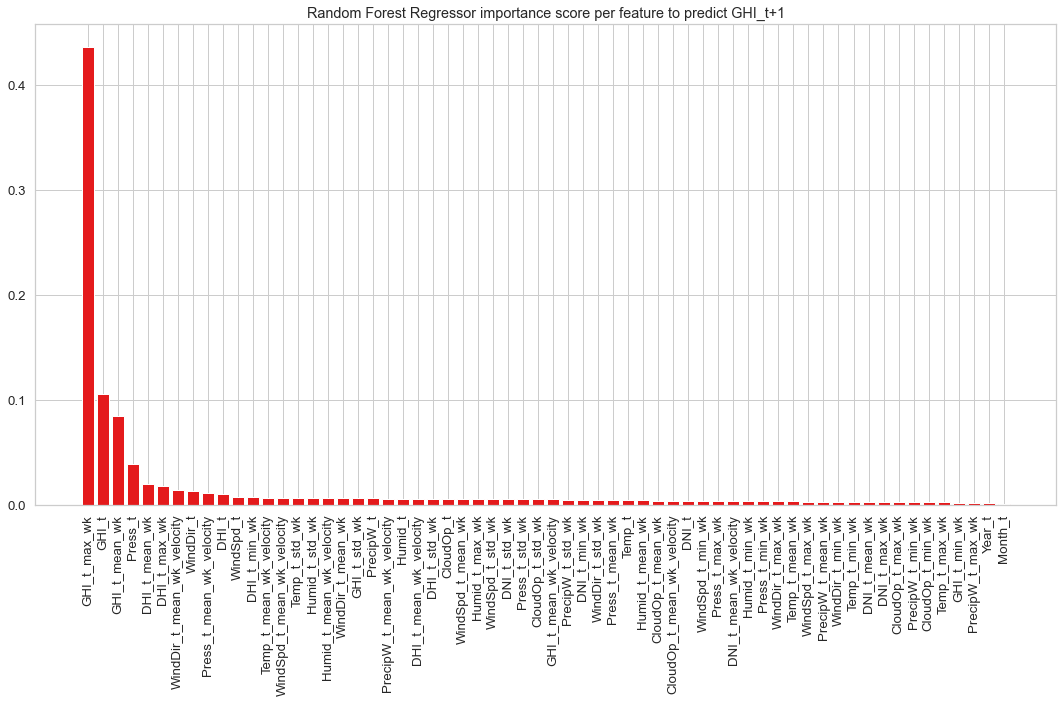

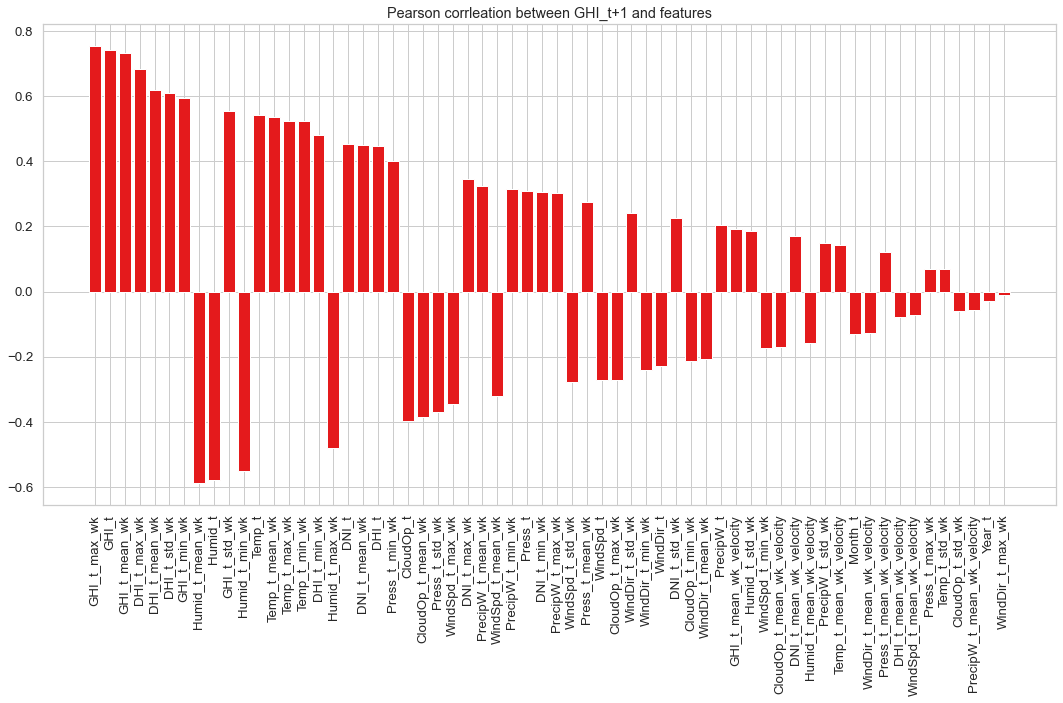

In [36]:
# visualize feature rfr importance score
plt.figure(figsize=(15, 10))
plt.bar(feat_importance.feature, feat_importance.rfr_importance)
plt.xticks(rotation=90)
plt.title('Random Forest Regressor importance score per feature to predict GHI_t+1')
plt.tight_layout()
plt.show()

# visualize feature rfr importance score
plt.figure(figsize=(15, 10))
plt.bar(feat_importance_temp.feature, feat_importance_temp.pearson_corr)
plt.xticks(rotation=90)
plt.title('Pearson corrleation between GHI_t+1 and features')
plt.tight_layout()
plt.show()

### Drop "weakest" drivers of daily solar energy on next day

In [37]:
# create a list of features to drop
feat_to_drop = []

for i in range(len(feat_importance)):
    if (feat_importance.loc[i, 'rfr_importance'] < np.quantile(feat_importance.rfr_importance, .25)) \
    | (abs(feat_importance.loc[i, 'pearson_corr']) < .25):
        feat_to_drop.append(list(feat_importance.feature)[i])

# drop features with poor importance score and or poor correlation
sol_fin_small = sol_temp.drop(
    labels=feat_to_drop,
    axis=1
)

In [38]:
sol_fin_small.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1075 entries, 2019-01-07 to 2021-12-16
Data columns (total 27 columns):
 #   Column             Non-Null Count  Dtype    
---  ------             --------------  -----    
 0   Year_month_t       1075 non-null   period[M]
 1   Temp_t             1075 non-null   float64  
 2   CloudOp_t          1075 non-null   float64  
 3   CloudOp_t_mean_wk  1075 non-null   float64  
 4   Humid_t            1075 non-null   float64  
 5   Humid_t_min_wk     1075 non-null   float64  
 6   Humid_t_max_wk     1075 non-null   float64  
 7   Humid_t_mean_wk    1075 non-null   float64  
 8   Press_t            1075 non-null   float64  
 9   Press_t_min_wk     1075 non-null   float64  
 10  Press_t_mean_wk    1075 non-null   float64  
 11  Press_t_std_wk     1075 non-null   float64  
 12  WindSpd_t          1075 non-null   float64  
 13  WindSpd_t_mean_wk  1075 non-null   float64  
 14  WindSpd_t_std_wk   1075 non-null   float64  
 15  DNI_t              1

### Save data

In [39]:
# create save path
save_path = '../data/formated/'

# save the dataset with all features
sol_fin_large = sol_temp.copy()
sol_fin_large_save_name = 'sol_fin_large.csv'
sol_fin_large.to_csv(save_path + sol_fin_large_save_name)

# save sol_temp dataframe as sol_fin
sol_fin_save_name = 'sol_fin_small.csv'
sol_fin_small.to_csv(save_path + sol_fin_save_name)

# save feat_importance dataframe
feat_importance_save_name = 'feat_imp.csv'
feat_importance.to_csv(save_path + feat_importance_save_name)